In [64]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import scipy.misc
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import os


graph_path = '/T26VOT_K[2, 14, 19, 22, 23, 33]'
graph_path = '/T26AVR_K[2, 14, 19, 22, 23, 33]'
graph_path = '/T26K33'
def acc_roc(multi,binary,yIdxPrediction,yLabelPrediction,yPredictionB,yLabelPredictionB,Rep,Sum,iters,graph_path, NO4, NO7, NO0, YES1, YES2):    

    NO = NO4 + NO7 + NO0
    YES = YES1 + YES2
    TOTAL = NO + YES
    
    # True Labels for Multi- and Binary Classification
    Y_true = [] ; Y_trueB = []
    for i in range(NO):
        Y_true.append(0)
        Y_trueB.append(0)
    for i in range(YES1):
        Y_true.append(1)
        Y_trueB.append(1)
    for i in range(YES2):
        Y_true.append(2)
        Y_trueB.append(1)
    Y_true = torch.tensor(Y_true) ; Y_trueB = torch.tensor(Y_trueB)

    tempMatrix1 = [0]*TOTAL ; tempMatrix2 = [0]*TOTAL ; tempMatrix3 = [0]*TOTAL
    
    for idx in range(TOTAL):
        tempMatrix1[yIdxPrediction[idx]] = yLabelPrediction[idx]  
    tempMatrix1 = torch.tensor(tempMatrix1)
    yLabelPrediction = tempMatrix1

    multi_class_confusion = confusion_matrix(Y_true, yLabelPrediction)
    tntp = np.diag(multi_class_confusion)
    correct = np.sum(tntp)
    printer('\n\n [Multi Class]\n',Rep,Sum)
    printer(str(tntp.ravel()),Rep,Sum)
    printer('\nAccuracy! %.3f' %(correct/len(Y_true)),Rep,Sum)
    printer('\nFolds:{}'.format(multi),Rep,Sum)
    

    if(type(Y_true)==torch.Tensor):
        Y_true = Y_true.numpy()
        yLabelPrediction = yLabelPrediction.numpy()

    scipy.io.savemat(os.getcwd()+graph_path+'/[%s%d%s%d]Y_true_M.mat' %(SETT,TRIAL,AUG,KERNEL_SEED),{"mydata": Y_true})
    scipy.io.savemat(os.getcwd()+graph_path+'/[%s%d%s%d]yLabelPrediction_M.mat' %(SETT,TRIAL,AUG,KERNEL_SEED),{"mydata": yLabelPrediction})


    if not("BN" in CONTROLTYPE):
        for idx in range(TOTAL):
            tempMatrix2[yIdxPrediction[idx]] = yPredictionB[idx]
            tempMatrix3[yIdxPrediction[idx]] = yLabelPredictionB[idx]
        tempMatrix2 = torch.tensor(tempMatrix2)
        yPredictionB = tempMatrix2
        tempMatrix3 = torch.tensor(tempMatrix3)
        yLabelPredictionB = tempMatrix3

        printer('\n\n [Binary Class]',Rep,Sum)
        tn, fp, fn, tp = confusion_matrix(Y_trueB, yLabelPredictionB).ravel()
        printer('\ntn %d, fp %d, fn %d, tp %d'%(tn, fp, fn, tp),Rep,Sum)
        printer('\nAccuracy! %.3f' %((tn+tp)/(tn+tp+fn+fp)),Rep,Sum)
        printer('\nFolds:{}'.format(binary),Rep,Sum)
        printer('\n\nSensitivity : %0.3f' %(tp/(fn+tp)),Rep,Sum)
        printer('\nSpecificity : %0.3f' %(tn/(tn+fp)),Rep,Sum)
        printer('\nF1_score : %.3f' %(f1_score(Y_trueB, yLabelPredictionB)),Rep,Sum)
        printer('\nAUROC : %.3f' %roc_auc_score(Y_trueB, yPredictionB),Rep,Sum)

        print('acc_roc: type',type(Y_trueB))
        print('acc_roc: Y_trueB',Y_trueB)
        if(type(Y_trueB)==torch.Tensor):
            print('\n\n Debug!!')
            Y_trueB = Y_trueB.numpy()
            yPredictionB = yPredictionB.numpy()
            yLabelPredictionB = yLabelPredictionB.numpy()    
        print('acc_roc: type',type(Y_trueB))
        print('acc_roc: Y_trueB',Y_trueB)

        scipy.io.savemat(os.getcwd()+graph_path+'/[%s%d%s%d]Y_true_B.mat' %(SETT,TRIAL,AUG,KERNEL_SEED),{"mydata": Y_trueB})
        scipy.io.savemat(os.getcwd()+graph_path+'/[%s%d%s%d]yPrediction_B.mat' %(SETT,TRIAL,AUG,KERNEL_SEED),{"mydata": yPredictionB})
        scipy.io.savemat(os.getcwd()+graph_path+'/[%s%d%s%d]yLabelPrediction_B.mat' %(SETT,TRIAL,AUG,KERNEL_SEED),{"mydata": yLabelPredictionB})

    
    if(SETT=='FUL'):
        num4=10 ; num7=20 ; num0=20
    elif(SETT=='SIG'):
        num4=24 ; num7=48 ; num0=48
    if not('ADNI' in CONTROLTYPE): balance(CONTROLTYPE,SETT,TRIAL,AUG,KERNEL_SEED,iters, NO4, NO7,NO0,YES1,YES2,num4,num7,num0,Sum)
    
def calbalcd(true,label,num,lst):
    check = len(true[true==num])
    if(check):
        where = np.where(true==num)
        corresd = label[where]
        cal = len(corresd[corresd==0]) / len(true[true==num])
        lst.append(cal)
        return lst
    else:
        return lst

    
def balance(CONTROLTYPE,SETT,TRIAL,AUG,KERNEL_SEED,iters, C4,C7,C0,C1,C2,num4,num7,num0,RR):
    np.random.seed(KERNEL_SEED)
    Y_true_M,                yLabelPrediction_M = loader(SETT,TRIAL,AUG, KERNEL_SEED,"M")
    Y_true_B, yPrediction_B, yLabelPrediction_B = loader(SETT,TRIAL,AUG, KERNEL_SEED,"B")
    yPrediction_M = []
    
    idx4 = np.arange(C4)
    idx7 = np.arange(C7) + C4
    idx0 = np.arange(C0) + C4 + C7
    idx1 = np.arange(C1) + C4 + C7 + C0
    idx2 = np.arange(C2) + C4 + C7 + C0 + C1
    right_len = len(idx2)
    
    multi_set = []  ;  multi_perf = []  ;  binary_set = [] ;  binary_perf = []
    tnn_set = [] ; fpn_set = [] ; tpl_set = [] ; fnl_set = [] ; tpr_set = [] ; fnr_set = []
    sens = [] ; spec = [] ; f1_scores = [] ; pr = [] ; roc = [] ; AUROCs = []
    
    M0s = []  ;  M4s = [] ; M7s = []
    B0s = []  ;  B4s = [] ; B7s = []
    Y_true_M[:C4] = 4
    Y_true_M[C4:C4+C7] = 7
    Y_true_B[:C4] = 4
    Y_true_B[C4:C4+C7] = 7

    for i in range(iters):
        M_true, M_label         = random_sample(idx4,idx7,idx0,idx1,idx2,num4,num7,num0, Y_true_M, yPrediction_M, yLabelPrediction_M,'M' )
        B_true, B_label, B_pred = random_sample(idx4,idx7,idx0,idx1,idx2,num4,num7,num0, Y_true_B, yPrediction_B, yLabelPrediction_B,'B' )
        
        M0s = calbalcd(M_true,M_label,0,M0s)
        M4s = calbalcd(M_true,M_label,4,M4s)
        M7s = calbalcd(M_true,M_label,7,M7s)
        B0s = calbalcd(B_true,B_label,0,B0s)
        B4s = calbalcd(B_true,B_label,4,B4s)
        B7s = calbalcd(B_true,B_label,7,B7s)
        M_true[M_true==4] = 0 ; M_true[M_true==7] = 0
        B_true[B_true==4] = 0 ; B_true[B_true==7] = 0
        
        multi_class_confusion = confusion_matrix(M_true, M_label)
        tntp = np.diag(multi_class_confusion)
        correct = np.sum(tntp)
        acc = correct/len(M_true)
        multi_set.append([tntp[0],tntp[1],tntp[2]]) ; multi_perf.append(acc)

        tn, fp, fn, tp = confusion_matrix(B_true, B_label).ravel()
        acc = (tn+tp)/(tn+fp+fn+tp)
        auc = roc_auc_score(B_true, B_pred)
        AUROCs.append(auc)
        f1 = f1_score(B_true, B_label)
        binary_set.append([tn,fp,fn,tp]) ; binary_perf.append([acc,auc])
        sens.append(tp/(tp+fn)) ; spec.append(tn/(tn+fp)) ; f1_scores.append(f1)

        num_yes = 2 * right_len
        BN = B_label[:num_yes]
        BL = B_label[num_yes:num_yes+right_len]
        BR = B_label[num_yes+right_len:]

        tnn = len(BN[BN==0]) ;  fpn = len(BN[BN==1])
        tpl = len(BL[BL==1]) ;  fnl = len(BL[BL==0])
        tpr = len(BR[BR==1]) ;  fnr = len(BR[BR==0])
    
        tnn_set.append(tnn) ; fpn_set.append(fpn)
        tpl_set.append(tpl) ; fnl_set.append(fnl)
        tpr_set.append(tpr) ; fnr_set.append(fnr)

        precisions, recalls, thresholds = precision_recall_curve(B_true, B_pred)
        pr.append([precisions,recalls,thresholds])
        fpr, true_pr, thresholds2 = roc_curve(B_true, B_pred) 
        roc.append([fpr,true_pr,thresholds2])
    
    
    RR.write('\n\n ======== [BALANCE] ========')
    RR.write('\n\n[Multi Control]\nZero: %.2f'%(np.average(M0s)))
    RR.write('\nFour: %.3f'%(np.average(M4s)))
    RR.write('\nSeven: %.3f\n'%(np.average(M7s)))
    RR.write('\n[Binary Control]\nZero: %.2f'%(np.average(B0s)))
    RR.write('\nFour: %.3f'%(np.average(B4s)))
    RR.write('\nSeven: %.3f\n'%(np.average(B7s)))

    sens = np.array(sens)
    spec = np.array(spec)
    f1_scores = np.array(f1_scores)
    AUROCs = np.array(AUROCs)

    balance_record(sens,spec,f1_scores,multi_set,multi_perf,binary_set,binary_perf,tnn_set, fpn_set,tpl_set,fnl_set,tpr_set,fnr_set,RR)
    
    return multi_set, binary_set, pr, roc, sens, spec, f1_scores,AUROCs

    

def loader(SETT,TRIAL,AUG,KERNEL_SEED,LRMB):
    yT = io.loadmat(os.getcwd()+graph_path+'/[%s%d%s%d]Y_true_%s.mat' %(SETT,TRIAL,AUG,KERNEL_SEED,LRMB))
    yL = io.loadmat(os.getcwd()+graph_path+'/[%s%d%s%d]yLabelPrediction_%s.mat' %(SETT,TRIAL,AUG,KERNEL_SEED,LRMB))
    Y_true = np.transpose(yT['mydata'])  ;  yLabelPrediction = np.transpose(yL['mydata'])
    if(LRMB!='M'):
        yP = io.loadmat(os.getcwd()+graph_path+'/[%s%d%s%d]yPrediction_%s.mat' %(SETT,TRIAL,AUG,KERNEL_SEED,LRMB))
        yPrediction = np.transpose(yP['mydata'])
        return Y_true, yPrediction, yLabelPrediction    
    else: 
        return Y_true, yLabelPrediction
    
    
def random_sample(idx4,idx7,idx0,idx1,idx2,num4,num7,num0,Y_true,yPrediction,yLabelPrediction,expr):
    
    if(expr=='M'):

        idxM7 = np.random.choice(idx7, num7//2, replace=False)
        idxM0 = np.random.choice(idx0, num0//2, replace=False)
        idxM1 = np.random.choice(idx1, len(idx2), replace=False)
        idxM2 = idx2
        
        true_NO0 = Y_true[idxM0]  ; true_NO7 = Y_true[idxM7]
        true_YES1 = Y_true[idxM1] ; true_YES2 = Y_true[idxM2]        
        label_NO0 = yLabelPrediction[idxM0]  ; label_NO7 = yLabelPrediction[idxM7]
        label_YES1 = yLabelPrediction[idxM1] ; label_YES2 = yLabelPrediction[idxM2]

        if(num4!=0):
            idxM4 = np.random.choice(idx4, num4//2, replace=False)
            true_NO4 = Y_true[idxM4] ; label_NO4 = yLabelPrediction[idxM4]
            true = np.vstack([true_NO4,true_NO7,true_NO0,true_YES1, true_YES2])
            label = np.vstack([label_NO4,label_NO7,label_NO0, label_YES1, label_YES2])
        else:
            true = np.vstack([true_NO7,true_NO0,true_YES1, true_YES2])
            label = np.vstack([label_NO7,label_NO0, label_YES1, label_YES2])

        return true, label
    
    elif(expr=='B'):
            
        idxB7 = np.random.choice(idx7, num7, replace=False)
        idxB0 = np.random.choice(idx0, num0, replace=False)
        idxB1 = np.random.choice(idx1,len(idx2),replace=False)
        idxBY = np.hstack([idxB1,idx2])

        true_NO0 = Y_true[idxB0] ; true_NO7 = Y_true[idxB7] ; true_YES = Y_true[idxBY]
        label_NO0 = yLabelPrediction[idxB0] ; label_NO7 = yLabelPrediction[idxB7] ; label_YES1 = yLabelPrediction[idxBY]
        pred_NO0 = yPrediction[idxB0] ; pred_NO7 = yPrediction[idxB7] ; pred_YES = yPrediction[idxBY]

        if(num4!=0):
            idxB4 = np.random.choice(idx4, num4, replace=False)
            true_NO4 = Y_true[idxB4] ; label_NO4 = yLabelPrediction[idxB4] ; pred_NO4 = yPrediction[idxB4]
            
            true = np.vstack([true_NO4,true_NO7,true_NO0, true_YES])
            label = np.vstack([label_NO4,label_NO7,label_NO0, label_YES1])
            pred = np.vstack([pred_NO4,pred_NO7,pred_NO0,pred_YES])
        else:
            true = np.vstack([true_NO7,true_NO0, true_YES])
            label = np.vstack([label_NO7,label_NO0, label_YES1])
            pred = np.vstack([pred_NO7,pred_NO0,pred_YES])
        
        return true, label, pred


def balance_record(sens,spec,f1_scores,multi_set,multi_perf,binary_set,binary_perf,tnn_set, fpn_set,tpl_set,fnl_set,tpr_set,fnr_set,RR):
        

    multi_set = np.round(np.average(multi_set,axis=0),1)
    multi_perf = np.round(np.average(multi_perf,axis=0),3)
    binary_set = np.round(np.average(binary_set,axis=0),0)
    binary_perf = np.round(np.average(binary_perf,axis=0),3)

    tnn = np.round(np.average(tnn_set,axis=0),1) ; fpn = np.round(np.average(fpn_set,axis=0),1)
    tpl = np.round(np.average(tpl_set,axis=0),1) ; fnl = np.round(np.average(fnl_set,axis=0),1)
    tpr = np.round(np.average(tpr_set,axis=0),1) ; fnr = np.round(np.average(fnr_set,axis=0),1)
    
    test = (binary_set[0] + binary_set[3]) / np.sum(binary_set)
    test = np.round(test,3)

    RR.write('\n\n[MULTI]')
    RR.write('\nNo Left Right\n')
    RR.write(str(multi_set))
    RR.write('\nAccuracy : ')
    RR.write(str(multi_perf))

    RR.write('\n\n[BINARY]')
    RR.write('\ntn fp fn tp\n')
    RR.write(str(binary_set))
    RR.write('\nAccuracy : ')
    RR.write(str(test))
    RR.write('\nSensitivity : %0.3f'%(np.average(sens)))
    RR.write('\nSpecificity : %0.3f'%(np.average(spec)))
    RR.write('\nF1-score : %0.3f'%(np.average(f1_scores)))
    RR.write('\nAUROC :')
    RR.write(str(binary_perf[1]))

    RR.write('\n\nTrue Negative NO : %s' %(str(tnn)))
    RR.write('\nFalse Positive NO : %s' %(str(fpn)))
    RR.write('\nNO : %s' %(str(np.round(tnn/(tnn+fpn),3))))

    RR.write('\n\nTrue Positive Left : %s' %(str(tpl)))
    RR.write('\nFalse Negative Left : %s' %(str(fnl)))
    RR.write('\nLeft : %s' %(str(np.round(tpl/(tpl+fnl),3))))

    RR.write('\n\nTrue Positive Right : %s' %(str(tpr)))
    RR.write('\nFalse Negative Right : %s' %(str(fnr)))
    RR.write('\nRight : %s' %(str(np.round(tpr/(tpr+fnr),3))))


In [66]:
# TEST SIG

KERNEL_SEED = 33
CONTROLTYPE = 'CLRM'
MODE = 'VOT'
SETT = 'FUL'
AUG = 'None'
msg = 'T26_Full'
TRIAL = 26

if('CV'in msg) :
    imgCountNO_4 = 28
    imgCountNO_7 = 66
    imgCountNO_0 = 66
    imgCountYES_1 = 100
    imgCountYES_2 = 60
elif('Full' in msg) :
    imgCountNO_0 =  168
    imgCountNO_7 = 69
    imgCountNO_4 = 15
    imgCountYES_1 = 25
    imgCountYES_2 = 25
    imgCountYES_3 = 0
    
num1=10 ; num2=20 ; num3=20
iters = 100

storage = './TEST_ensembleStorage.txt'
fwSt=open(storage,'a')
ms, bs, pr, roc, sens, spec, f1_scores,AUROCs = balance(CONTROLTYPE,SETT,TRIAL,AUG,KERNEL_SEED,iters, imgCountNO_4, imgCountNO_7,imgCountNO_0,imgCountYES_1,imgCountYES_2,num1,num2,num3, fwSt)
fwSt.close()

In [67]:
import numpy as np
import scipy.stats
import scipy

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    print(m)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    
    check = scipy.stats.normaltest(data)
    men = data.mean()
    std = data.std()
    new_data = (data-men)/std
#    print('mean:',new_data.mean())
#    print('std:',new_data.std())
    if(check[1]>=1e-3): print('NORMAL')
    print(np.round(m,3))
    print(np.round(m-h,3))
    print(np.round(m+h,3))


In [68]:
67.7/75

0.9026666666666667

In [69]:
ms = np.array(ms)
print('NoHS')
mean_confidence_interval(ms[:,0]/25)

print('\nTotal Multi')
ms = np.array(ms)
ms2 = np.sum(ms,axis=1) / 75
mean_confidence_interval(ms2)

print('\nBinary')
binary = (sens + spec)/2
mean_confidence_interval(binary)

print('\nSpecificity')
mean_confidence_interval(spec)

print('\nF1')
mean_confidence_interval(f1_scores)

print('\nAUROC')
mean_confidence_interval(AUROCs)


NoHS
0.7536000000000002
0.754
0.737
0.77

Total Multi
0.7178666666666668
0.718
0.712
0.723

Binary
0.824
NORMAL
0.824
0.819
0.829

Specificity
0.748
NORMAL
0.748
0.737
0.759

F1
0.8369359969876785
NORMAL
0.837
0.833
0.841

AUROC
0.89696
NORMAL
0.897
0.894
0.9


In [63]:
ms = np.array(ms)
bs = np.array(bs)
pr = np.array(pr)
roc = np.array(roc)

ms2 = np.sum(ms,axis=1) / 75
bs2 = bs[:,0] + bs[:,3] 
bs2 = bs2/100

def avgstd(arr):
    print('average: %0.3f'%(np.average(arr)))
    print('std: %0.3f'%(np.std(arr)))
    print('\n')
    
avgstd(ms2)
avgstd(bs2)
avgstd(sens)
avgstd(spec)
avgstd(f1_scores)

average: 0.719
std: 0.026


average: 0.810
std: 0.026


average: 0.880
std: 0.000


average: 0.741
std: 0.053


average: 0.823
std: 0.020




/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


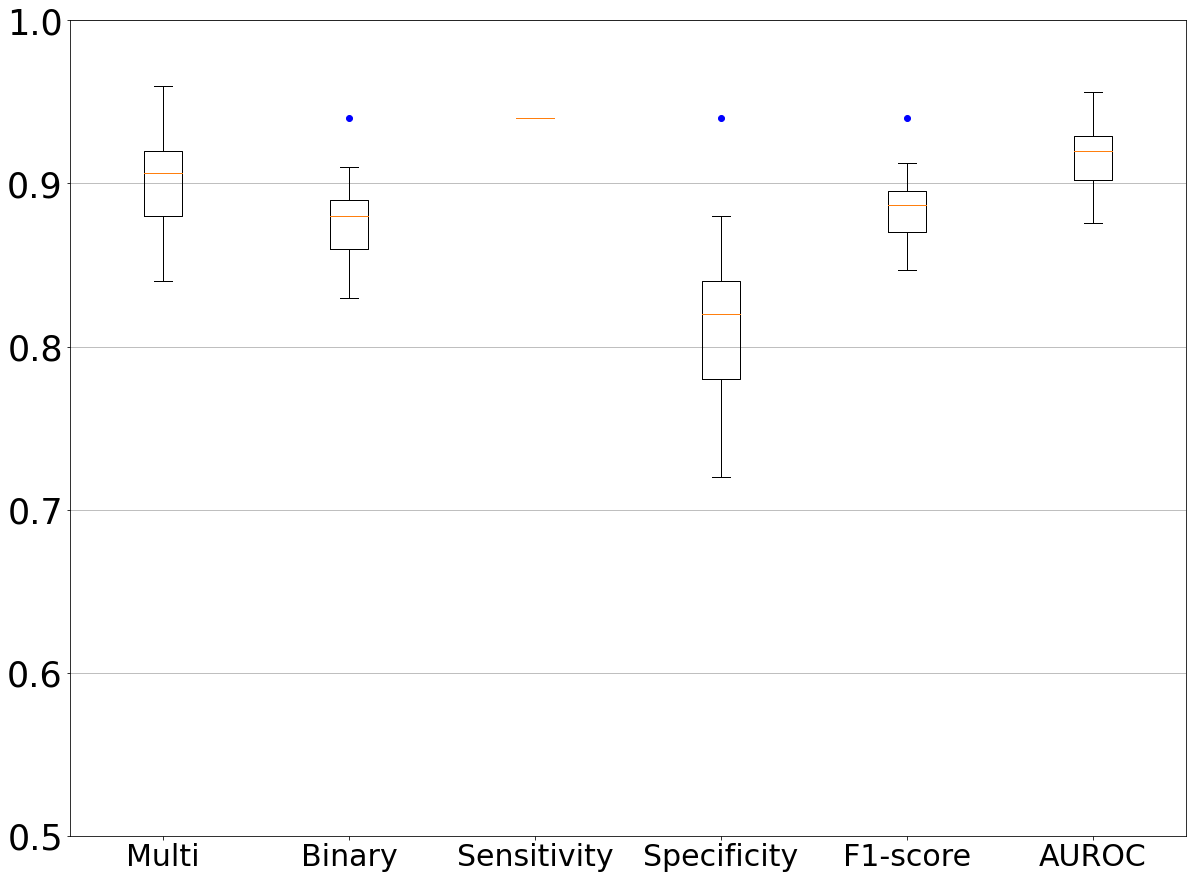

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline


box_width = 0.2
fig, ax = plt.subplots(figsize=(20,15))

ax.boxplot([ms2, bs2, sens,spec,f1_scores,AUROCs], sym="b", widths=(box_width,box_width,box_width,box_width,box_width,box_width))
#plt.title('One Hundred Iterations', fontsize=40)
plt.xticks([1,2,3, 4,5,6], ['Multi', 'Binary', 'Sensitivity','Specificity','F1-score','AUROC'], fontsize=30)
plt.yticks(fontsize=35)
plt.ylim([0.5, 1.0])    # Diverse
plt.grid(True, axis='y')
saveFileName = './figure/One_Hundred_Boxplot_%s.png' %(MODE)
plt.savefig(saveFileName)
plt.show()


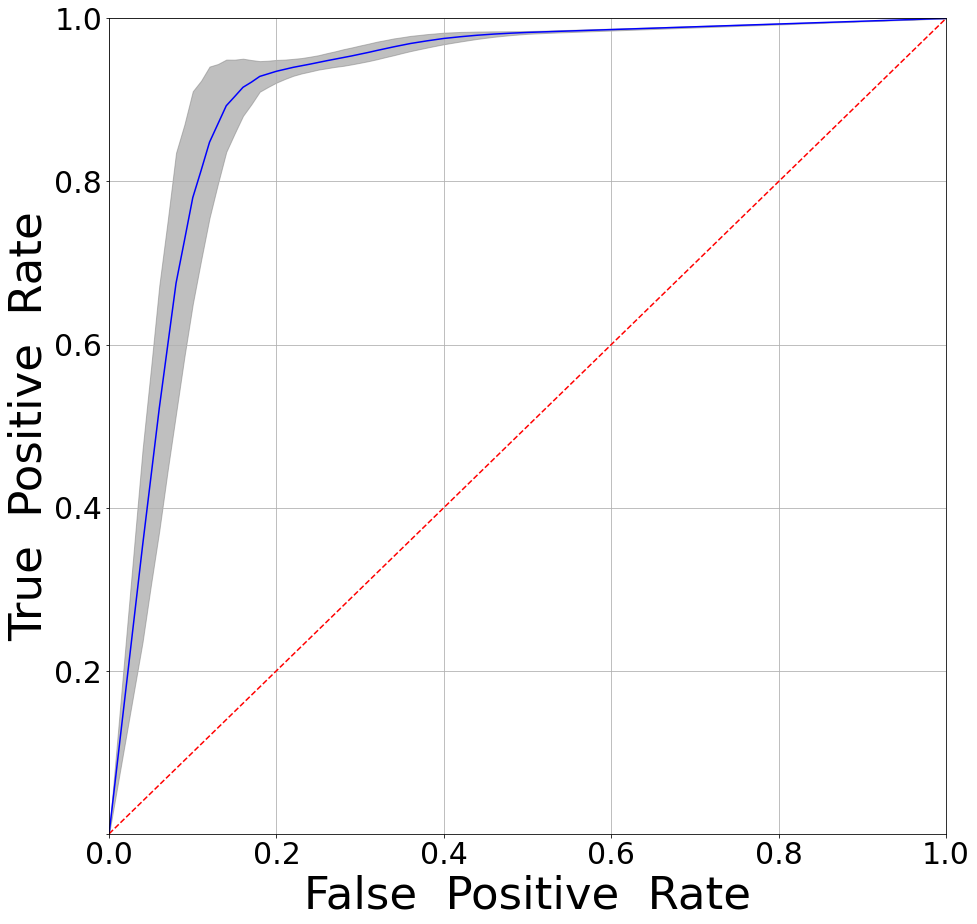

In [44]:
from numpy import interp
from matplotlib.ticker import MaxNLocator

plt.rc('axes', labelsize=35)  
plt.rc('xtick', labelsize=30)    # fontsize of the tick labels
plt.rc('ytick', labelsize=30)    # fontsize of the tick labels

tprs = []
base_fpr = np.linspace(0, 1, 101)
plt.figure(figsize=(15, 15))
#plt.title('Average ROC curve', fontsize=30)

for i in range(len(roc)):
    fpr, tpr, _ = roc[i]
#    plt.plot(fpr, tpr, 'b', alpha=0.05)
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)
tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.5)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('True  Positive  Rate',fontsize=45)
plt.xlabel('False  Positive  Rate',fontsize=45)
plt.grid(True)

plt.gca().yaxis.get_majorticklabels()[0].set_visible(False)

saveFileName = './figure/AverageAUROC_%s.png' %(MODE)
plt.savefig(saveFileName)
plt.show()